# GA Otimizado

In [2]:
!pip install deap


Carregando e prÃ©-processando imagem...
Executando algoritmo de Gerchberg-Saxton...
 	IteraÃ§Ã£o GS (X) 10/200, CorrelaÃ§Ã£o: 0.9607
 	IteraÃ§Ã£o GS (X) 20/200, CorrelaÃ§Ã£o: 0.9680
 	IteraÃ§Ã£o GS (X) 30/200, CorrelaÃ§Ã£o: 0.9719
 	IteraÃ§Ã£o GS (X) 40/200, CorrelaÃ§Ã£o: 0.9737
 	IteraÃ§Ã£o GS (X) 50/200, CorrelaÃ§Ã£o: 0.9745
 	IteraÃ§Ã£o GS (X) 60/200, CorrelaÃ§Ã£o: 0.9748
 	IteraÃ§Ã£o GS (X) 70/200, CorrelaÃ§Ã£o: 0.9752
 	IteraÃ§Ã£o GS (X) 80/200, CorrelaÃ§Ã£o: 0.9757
 	IteraÃ§Ã£o GS (X) 90/200, CorrelaÃ§Ã£o: 0.9760
 	IteraÃ§Ã£o GS (X) 100/200, CorrelaÃ§Ã£o: 0.9762
 	IteraÃ§Ã£o GS (X) 110/200, CorrelaÃ§Ã£o: 0.9764
 	IteraÃ§Ã£o GS (X) 120/200, CorrelaÃ§Ã£o: 0.9765
 	IteraÃ§Ã£o GS (X) 130/200, CorrelaÃ§Ã£o: 0.9766
 	IteraÃ§Ã£o GS (X) 140/200, CorrelaÃ§Ã£o: 0.9766
 	IteraÃ§Ã£o GS (X) 150/200, CorrelaÃ§Ã£o: 0.9766
 	IteraÃ§Ã£o GS (X) 160/200, CorrelaÃ§Ã£o: 0.9766
 	IteraÃ§Ã£o GS (X) 170/200, CorrelaÃ§Ã£o: 0.9766
 	IteraÃ§Ã£o GS (X) 180/200, CorrelaÃ§Ã£o: 0.9766
 	IteraÃ§Ã£o GS (X) 190/2

  Mapa Dammann (Y) gerado: (90, 90) pixels
GeraÃ§Ã£o de Fase ConcluÃ­da.
Iniciando anÃ¡lise e plotagem...
Plot 1: Gerando plot_mapa_fase.png...
Plot 2: Gerando plot_erro_gs.png...
AnÃ¡lise: Calculando Far-Field da metassuperfÃ­cie completa...
AnÃ¡lise: Extraindo ordens de difraÃ§Ã£o...
AnÃ¡lise concluÃ­da. Encontradas 1513 ordens propagantes.
Plot 3: Gerando plot_far_field.png...
Plot 4: Gerando plot_ordens_scatter.png...

Todos os plots foram salvos como arquivos .png.

--- Resumo das Ordens ---
    p  q     intensity            k_p            k_q
0 -21 -6  48415.277409 -897435.897436 -256410.256410
1 -21 -5  44099.576047 -897435.897436 -213675.213675
2 -21 -4  47457.195916 -897435.897436 -170940.170940
3 -21 -3  41993.310106 -897435.897436 -128205.128205
4 -21 -2  38967.541269 -897435.897436  -85470.085470
Gerador '/content/generator_teste_5_final.pth' carregado em cuda.
Simulador '/content/simulador_NG_teste_1.pth' carregado em cuda.
Grade de coordenadas criada.

⚙️ Iniciando otimiz

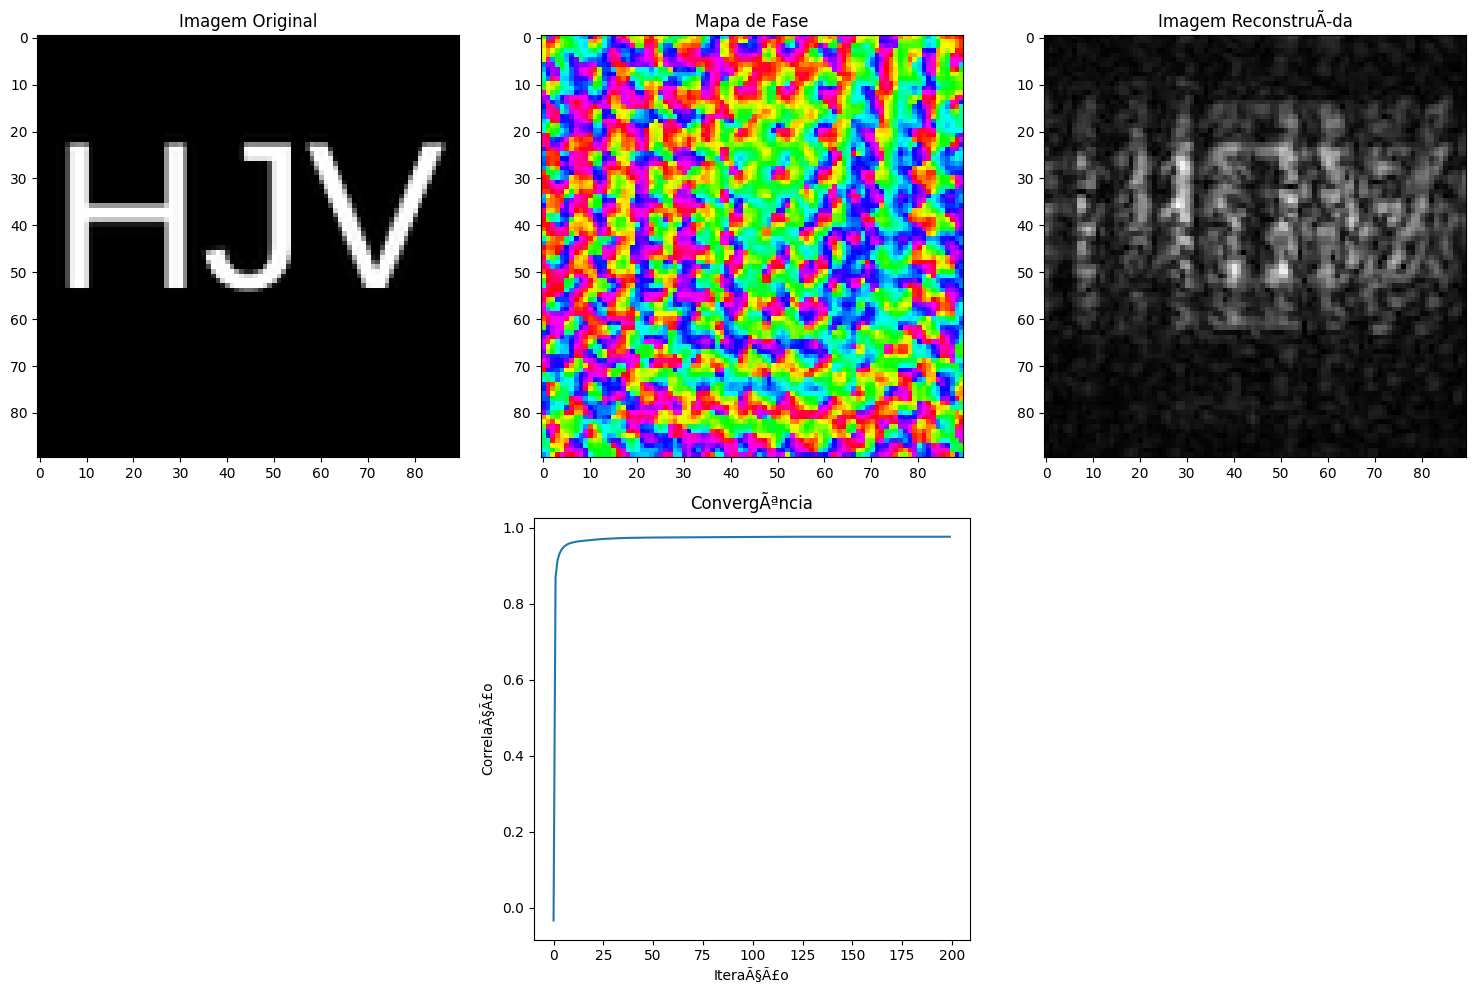

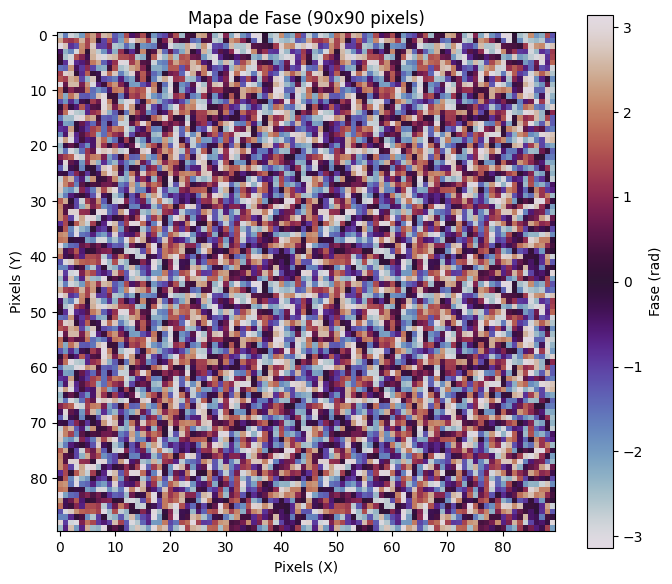

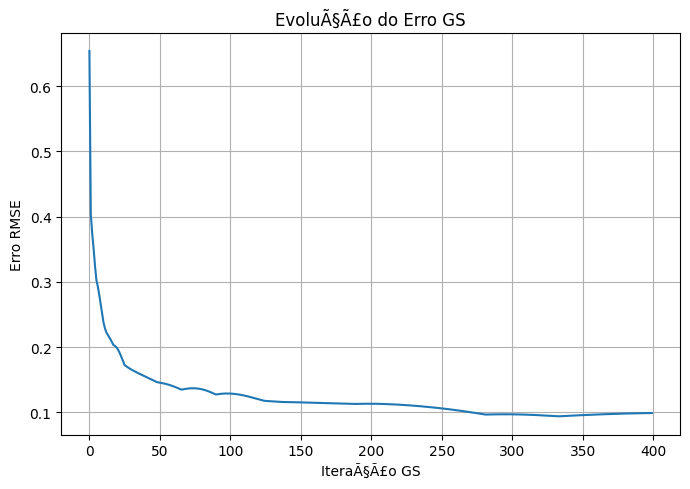

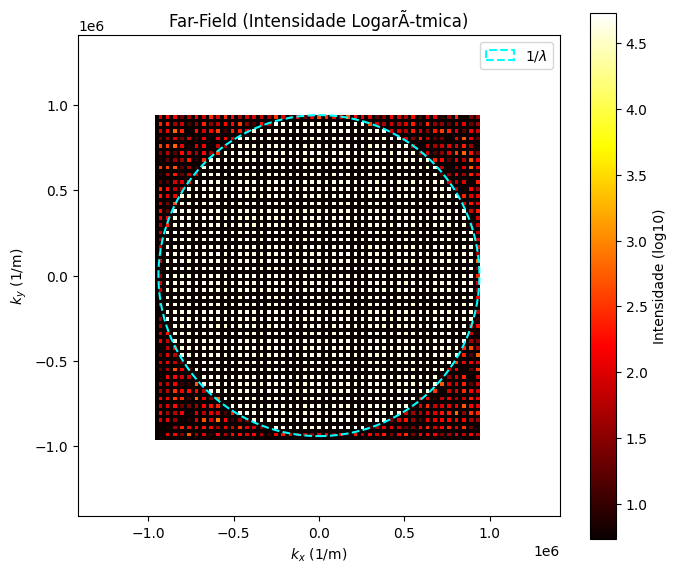

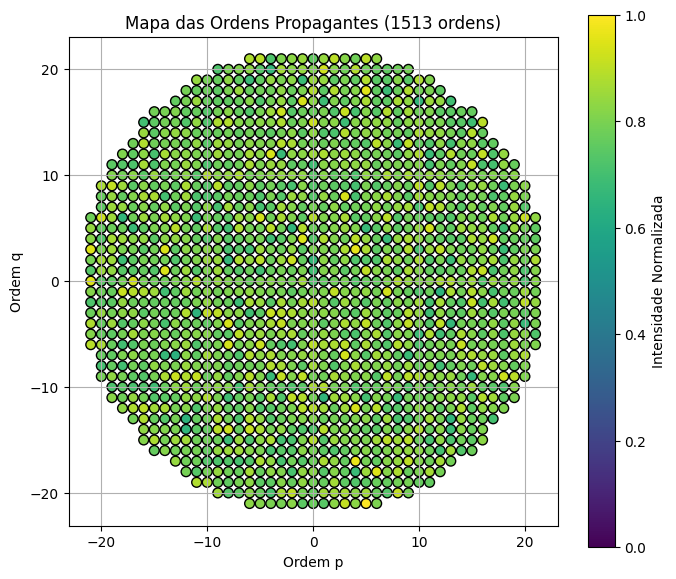

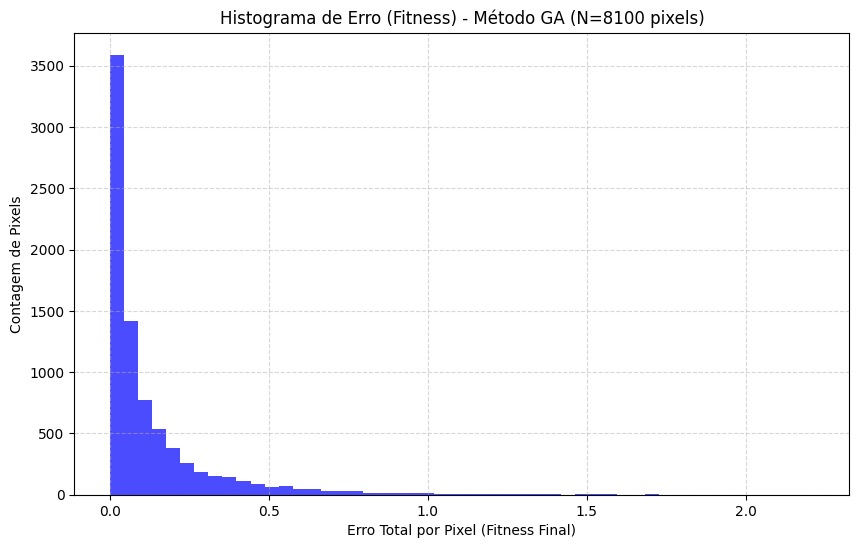

Métricas salvas com sucesso em 'optimization_metrics.txt'

Verificando performance final (em lotes) da metassuperfície otimizada...


Verificando linhas: 100%|██████████| 90/90 [00:05<00:00, 17.02it/s]


Verificação em lote concluída.

--- Gerando Imagem da Metassuperfície Completa ---
Isso pode demorar alguns minutos e consumir bastante RAM...


Gerando Linhas da Metassuperfície: 100%|██████████| 90/90 [00:02<00:00, 33.35it/s]


Costurando imagem final...
Imagem final gerada com dimensões: (5760, 5760)
Imagem da metassuperfície completa salva em: metasurface_completa_geometria_GA_Teste_1_10_11_25.png

Reconstruindo imagem final a partir do campo otimizado pelo GA...
Reconstrução final (GA) concluída.
Gerando gráfico de comparação de reconstrução (GA)...


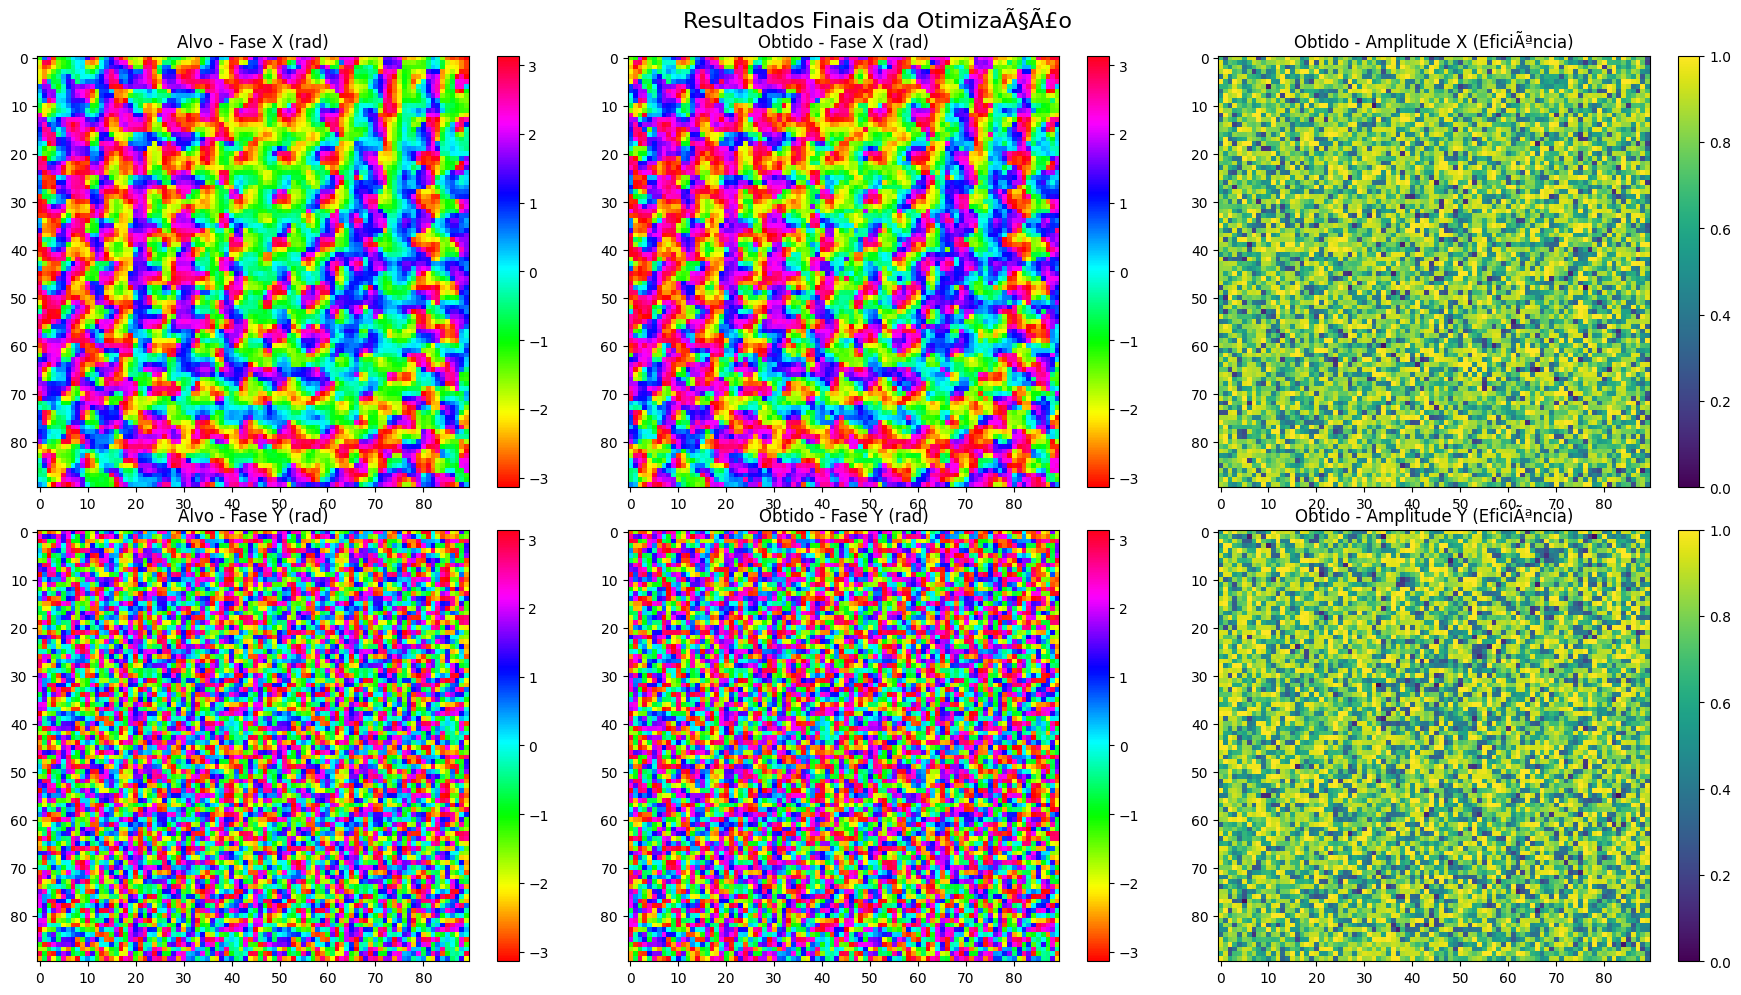

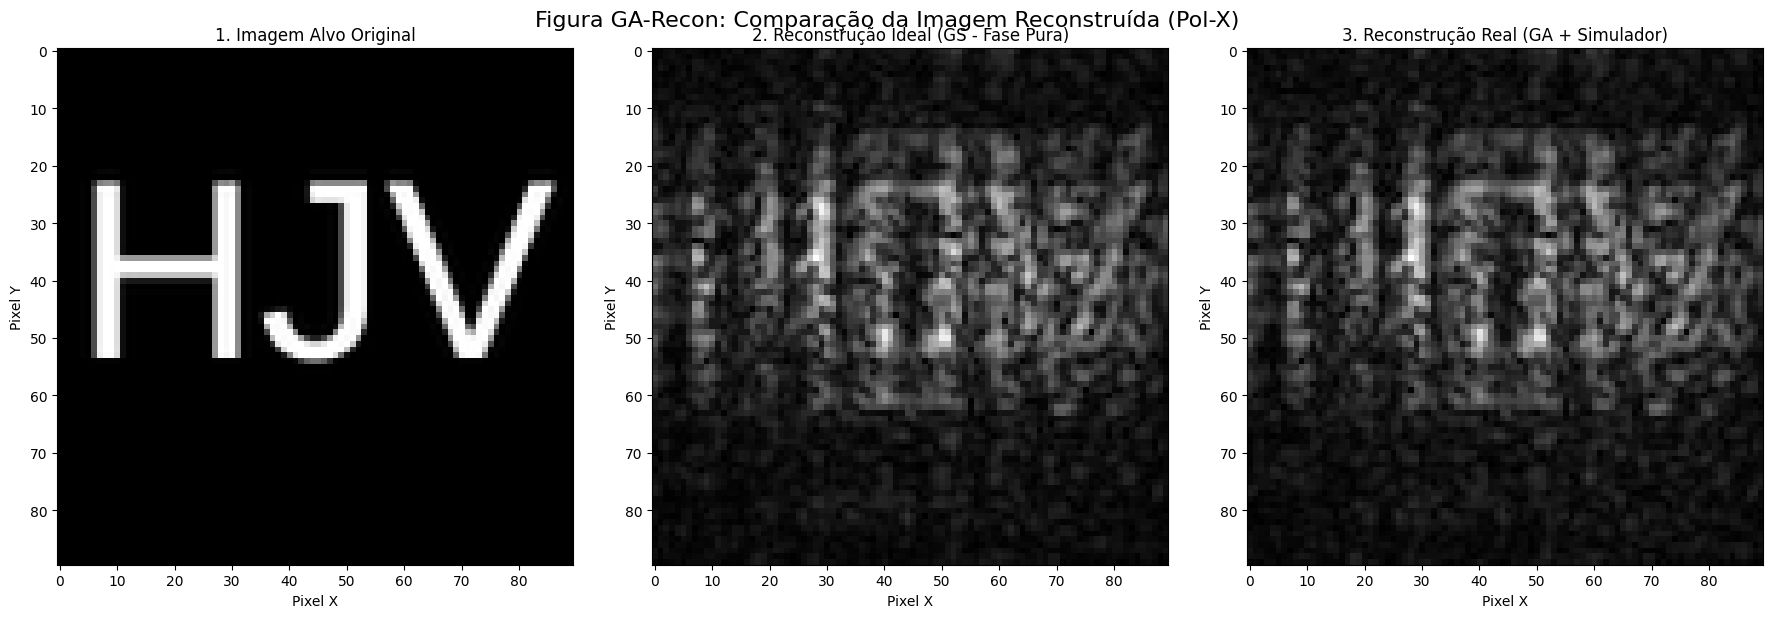

Gráfico 'comparacao_reconstrucao_GA.png' salvo.


In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from joblib import Parallel, delayed
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from deap import base, creator, tools, algorithms

"""## Estruturas para utilizar o Simulador e o Gerador"""

class ResBlock(nn.Module):
    """
    Define um bloco ResNet bÃ¡sico
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.main_path = nn.Sequential(

            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

        self.shortcut_path = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut_path = nn.Sequential(

                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.main_path(x) + self.shortcut_path(x)
        out = F.relu(out)
        return out

# N_OUTPUTS Ã© quantos valores se quer prever
N_OUTPUTS = 4

class ResNetSimulator(nn.Module):
    """
    ImplementaÃ§Ã£o do Simulator baseado em ResNet.
    """
    def __init__(self, in_channels=1, n_outputs=N_OUTPUTS):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.layer1 = ResBlock(64, 64, stride=1)

        self.layer2 = ResBlock(64, 128, stride=2)

        self.layer3 = ResBlock(128, 256, stride=2)

        self.layer4 = ResBlock(256, 256, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))

        self.head = nn.Sequential(
            nn.Linear(256 * 2 * 2, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, n_outputs)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.head(out)
        return out

class Sin(nn.Module):
    def forward(self, x): return torch.sin(x)

class Gaussian(nn.Module):
    def forward(self, x): return torch.exp(-x**2)

def make_coordinate_grid(size, device='cpu'):
    """Cria grade de coordenadas (x, y)"""
    xs = np.linspace(-1, 1, size)
    ys = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(xs, ys)

    coords = np.stack([xx.ravel(), yy.ravel()], axis=-1).astype(np.float32)
    return torch.from_numpy(coords).to(device) # shape (size*size, 2)

class CPPN_Generator(nn.Module):
    """
    Gerador CPPN. Mapeia (vetor latente 'v' + coords 'x,y,r') -> pixel.
    """
    def __init__(self, latent_dim, in_coords=2, out_channels=1, hidden_dim=64):
            super().__init__()
            self.latent_dim = latent_dim
            self.in_coords = in_coords
            self.out_channels = out_channels

            input_dim = in_coords + latent_dim

            self.net = nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.Tanh(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),

                nn.Linear(hidden_dim, hidden_dim),
                Sin(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.LeakyReLU(0.2),

                nn.Linear(hidden_dim, hidden_dim),
                Gaussian(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),

                nn.Linear(hidden_dim, hidden_dim),
                Sin(),

                nn.Linear(hidden_dim, hidden_dim),
                Gaussian(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.Tanh(),

                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),

                nn.Linear(hidden_dim, hidden_dim),
                Sin(),

                nn.Linear(hidden_dim, out_channels),
                nn.Sigmoid()
            )

    def forward(self, coords, v):

        v_expanded = v.unsqueeze(1)
        v_tiled = v_expanded.repeat(1, coords.size(0), 1)

        coords_tiled = coords.unsqueeze(0).repeat(v.size(0), 1, 1)

        combined_input = torch.cat([coords_tiled, v_tiled], dim=-1)

        output = self.net(combined_input)

        img_size = int(np.sqrt(coords.size(0)))

        output = output.permute(0, 2, 1).view(-1, self.out_channels, img_size, img_size)

        return output

"""# Mapas de Fase

CriaÃ§Ã£o do mapa de fase para a polarizaÃ§Ã£o x:
"""

def load_and_preprocess_image(image_path, target_size=(450, 450)):
    """
    Carrega e prÃ©-processa a imagem alvo usando PIL
    """
    try:
        image = Image.open(image_path).convert('L')
        image = image.resize(target_size, Image.LANCZOS)
        image_array = np.array(image, dtype=np.float64)
        image_array = image_array / np.max(image_array)
        return image_array
    except FileNotFoundError:
        print(f"AtenÃ§Ã£o: Imagem '{image_path}' nÃ£o encontrada. Criando imagem de teste...")
        target_image = np.zeros(target_size)
        target_image[150:300, 100:200] = 1.0
        target_image[150:200, 200:350] = 1.0
        target_image[250:300, 200:350] = 1.0
        return target_image

def apply_zero_padding(image, padding_factor=2):
    """
    Aplica zero-padding Ã  imagem
    """
    original_size = image.shape
    padded_size = (image.shape[0] * padding_factor, image.shape[1] * padding_factor)
    padded_image = np.zeros(padded_size, dtype=complex)

    start_row = (padded_size[0] - original_size[0]) // 2
    start_col = (padded_size[1] - original_size[1]) // 2
    padded_image[start_row:start_row+original_size[0],
                 start_col:start_col+original_size[1]] = image

    return padded_image, original_size

def create_low_pass_filter(shape, wavelength, dx, NA):
    """
    Cria filtro passa-baixa baseado na abertura numÃ©rica
    """
    nx, ny = shape
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    f_cutoff = NA / wavelength
    freq_radius = np.sqrt(FX**2 + FY**2)
    filter_mask = (freq_radius <= f_cutoff).astype(np.float64)

    return filter_mask

def angular_spectrum_propagation(U, wavelength, z, dx, filter_mask=None):
    """
    Propaga o campo usando mÃ©todo do espectro angular
    """
    k = 2 * np.pi / wavelength
    nx, ny = U.shape

    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    root_term = 1 - (wavelength * FX)**2 - (wavelength * FY)**2
    root_term[root_term < 0] = 0

    H = np.exp(1j * k * z * np.sqrt(root_term))

    if filter_mask is not None:
        H = H * filter_mask

    U_freq = fft2(U)
    U_prop_freq = U_freq * H
    U_prop = ifft2(U_prop_freq)

    return U_prop

def calculate_correlation(target, reconstructed):
    """
    Calcula a correlaÃ§Ã£o de Pearson entre duas imagens (valores reais)
    """
    target_real = np.real(target).flatten()
    reconstructed_real = np.real(reconstructed).flatten()

    correlation = np.corrcoef(target_real, reconstructed_real)[0, 1]

    if np.isnan(correlation):
        return 0.0

    return float(correlation)

def extract_center(image, original_size):
    """
    Extrai regiÃ£o central da imagem (remove padding)
    """
    nx, ny = original_size
    start_row = (image.shape[0] - nx) // 2
    start_col = (image.shape[1] - ny) // 2
    return image[start_row:start_row+nx, start_col:start_col+ny]

def reconstruct_image(phase_map, wavelength, z, dx, NA):
    """
    ReconstrÃ³i a imagem a partir do mapa de fase
    """
    # Aplica zero-padding ao mapa de fase
    phase_padded, original_size = apply_zero_padding(np.exp(1j * phase_map))

    # Cria filtro
    filter_mask = create_low_pass_filter(phase_padded.shape, wavelength, dx, NA)

    # Propaga para o plano da imagem
    reconstructed = angular_spectrum_propagation(phase_padded, wavelength, z, dx, filter_mask)

    # Extrai regiÃ£o central e pega a amplitude (np.abs)
    reconstructed = extract_center(np.abs(reconstructed), original_size)

    return np.real(reconstructed)  # Garante valor real

def reconstruct_image_from_field(complex_field, wavelength, z, dx, NA):
    """
    Reconstrói a imagem a partir de um CAMPO COMPLEXO (Amp + Fase)
    """
    # 1. Aplica zero-padding ao campo complexo
    field_padded, original_size = apply_zero_padding(complex_field)

    # 2. Cria filtro
    filter_mask = create_low_pass_filter(field_padded.shape, wavelength, dx, NA)

    # 3. Propaga para o plano da imagem
    reconstructed = angular_spectrum_propagation(field_padded, wavelength, z, dx, filter_mask)

    # 4. Extrai região central e pega a amplitude (np.abs)
    reconstructed_center = extract_center(reconstructed, original_size)
    reconstructed_amplitude = np.abs(reconstructed_center)

    return np.real(reconstructed_amplitude) # Garante valor real

def gerchberg_saxton_angular_spectrum(target, wavelength, z, dx, NA, num_iter=50):
    """
    Algoritmo de Gerchberg-Saxton com espectro angular
    Retornar a imagem original e a reconstruÃ­da
    """
    target_padded, original_size = apply_zero_padding(target)
    nx_pad, ny_pad = target_padded.shape

    filter_mask = create_low_pass_filter((nx_pad, ny_pad), wavelength, dx, NA)

    phase = np.random.rand(nx_pad, ny_pad) * 2 * np.pi
    U = target_padded * np.exp(1j * phase)

    correlations = []

    for i in range(num_iter):
        # 1. Propaga para o plano da imagem
        U_image = angular_spectrum_propagation(U, wavelength, z, dx, filter_mask)

        # 2. MantÃ©m a fase, atualiza amplitude com alvo
        amplitude_image = np.abs(U_image)
        phase_image = np.angle(U_image)

        # Calcula correlaÃ§Ã£o para monitorar convergÃªncia
        target_region = extract_center(target_padded, original_size)
        recon_region = extract_center(amplitude_image, original_size)

        corr = calculate_correlation(target_region, recon_region)
        correlations.append(corr)

        # Atualiza campo no plano da imagem
        U_image_updated = target_padded * np.exp(1j * phase_image)

        # 3. Propaga de volta para o plano do holograma
        U = angular_spectrum_propagation(U_image_updated, wavelength, -z, dx, filter_mask)

        # 4. MantÃ©m a fase, atualiza amplitude com incidente (unitÃ¡ria)
        phase_hologram = np.angle(U)
        U = np.exp(1j * phase_hologram) # Amplitude unitÃ¡ria (holograma de fase)

        if (i + 1) % 10 == 0:
            print(f" 	IteraÃ§Ã£o GS (X) {i+1}/{num_iter}, CorrelaÃ§Ã£o: {corr:.4f}")

    phase_final = extract_center(np.angle(U), original_size)

    reconstructed_image = reconstruct_image(phase_final, wavelength, z, dx, NA)

    return target, reconstructed_image, phase_final, correlations

wavelength = 1064e-9  # 1064 nm
z = 380e-6           # 380 Î¼m
dx = 520e-9          # pixel pitch
NA = 0.65            # abertura numÃ©rica
num_iter = 200       # nÃºmero de iteraÃ§Ãµes

print("Carregando e prÃ©-processando imagem...")
target_original = load_and_preprocess_image('/content/HJV.png', target_size=(90, 90))

print("Executando algoritmo de Gerchberg-Saxton...")

img_original, img_reconstruida, mapa_de_fase, correlations = gerchberg_saxton_angular_spectrum(
    target_original,
    wavelength,
    z,
    dx,
    NA,
    num_iter
)
print(f"\nCorrelaÃ§Ã£o final: {correlations[-1]:.4f}")

print(f"DimensÃµes da Imagem Original: {img_original.shape}")
print(f"DimensÃµes da Imagem ReconstruÃ­da: {img_reconstruida.shape}")
print(f"DimensÃµes do Mapa de Fase: {mapa_de_fase.shape}")

# np.savetxt('phase_map_x_polarization.txt', mapa_de_fase)
# np.savetxt('correlations.txt', correlations)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(img_original, cmap='gray')
plt.title('Imagem Original')

plt.subplot(2, 3, 2)
plt.imshow(mapa_de_fase, cmap='hsv')
plt.title('Mapa de Fase')

plt.subplot(2, 3, 3)
plt.imshow(img_reconstruida, cmap='gray')
plt.title('Imagem ReconstruÃ­da')

plt.subplot(2, 3, 5)
plt.plot(correlations)
plt.title('ConvergÃªncia')
plt.xlabel('IteraÃ§Ã£o')
plt.ylabel('CorrelaÃ§Ã£o')

plt.tight_layout()
#plt.show()

"""## PolarizaÃ§Ã£o y:"""

def generate_dammann_phase_map(
    P: float = 520e-9,
    wavelength: float = 1064e-9,
    supercell_pixels: int = 45,
    n_supercells: int = 2,
    iters_gs: int = 400,
    random_seed: int = 0,
    verbose: bool = True
) -> tuple[np.ndarray, dict, list]:
    """
    Gera o mapa de fase para uma grade de Dammann (spot-cloud) usando o algoritmo GS.
    """
    np.random.seed(random_seed)

    N_super = supercell_pixels
    dx = P
    d = dx * N_super

    # --- Grade k e alvo ---
    # (Esta funÃ§Ã£o usa np.fft, o que nÃ£o conflita com o Bloco 1)
    kx = np.fft.fftfreq(N_super, d=dx)
    ky = np.fft.fftfreq(N_super, d=dx)
    kx_shift = np.fft.fftshift(kx)
    ky_shift = np.fft.fftshift(ky)
    KX, KY = np.meshgrid(kx_shift, ky_shift)
    K_rad = np.sqrt(KX**2 + KY**2)
    target_radius = min(1.0 / wavelength, 1.0 / (2.0 * dx))
    target_amp = (K_rad <= target_radius).astype(float)

    # --- Algoritmo GS ---
    plane_field = np.exp(1j * 2.0 * np.pi * np.random.rand(N_super, N_super))
    errors = []

    # Loop de iteraÃ§Ã£o para Dammann
    gs_iterator = range(iters_gs)
    if verbose:
        # Cria uma barra de progresso se 'verbose' for True
        gs_iterator = tqdm(range(iters_gs), desc="  IteraÃ§Ãµes GS (Y)", leave=False)

    for it in gs_iterator:
        far = np.fft.fft2(plane_field)
        far_shift = np.fft.fftshift(far)

        amp_current = np.abs(far_shift)
        err = np.sqrt(np.mean((amp_current / (amp_current.max() + 1e-9) - target_amp)**2))
        errors.append(err)

        far_shift = target_amp * np.exp(1j * np.angle(far_shift))
        far = np.fft.ifftshift(far_shift)

        plane_field = np.fft.ifft2(far)
        plane_field = np.exp(1j * np.angle(plane_field))

    supercell_phase = np.angle(plane_field)

    # --- ConstruÃ§Ã£o da MetassuperfÃ­cie Completa ---
    full_phase = np.tile(supercell_phase, (n_supercells, n_supercells))

    if verbose:
        print(f"  Mapa Dammann (Y) gerado: {full_phase.shape} pixels")

    metrics = {} # Vazio, focado apenas na geraÃ§Ã£o de fase

    return full_phase, metrics, errors

def analyze_and_plot_results(
    full_phase: np.ndarray,
    errors: list,
    P: float,
    wavelength: float,
    supercell_pixels: int
) -> pd.DataFrame:
    """
    Analisa e plota os resultados da metassuperfÃ­cie.
    Retorna um DataFrame com os dados das ordens propagantes.
    """

    print("Iniciando anÃ¡lise e plotagem...")

    # --- Plot 1: Mapa de Fase ---
    print("Plot 1: Gerando plot_mapa_fase.png...")
    plt.figure(figsize=(7, 6))
    plt.imshow(full_phase, cmap='twilight', extent=None)
    plt.colorbar(label="Fase (rad)")
    plt.title(f"Mapa de Fase ({full_phase.shape[0]}x{full_phase.shape[1]} pixels)")
    plt.xlabel("Pixels (X)")
    plt.ylabel("Pixels (Y)")
    plt.tight_layout()
    plt.savefig("plot_mapa_fase.png", dpi=150)

    # --- Plot 2: EvoluÃ§Ã£o do Erro ---
    print("Plot 2: Gerando plot_erro_gs.png...")
    plt.figure(figsize=(7, 5))
    plt.plot(errors)
    plt.xlabel("IteraÃ§Ã£o GS")
    plt.ylabel("Erro RMSE")
    plt.title("EvoluÃ§Ã£o do Erro GS")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("plot_erro_gs.png", dpi=150)

    # --- AnÃ¡lise de Far-Field (CÃ©lulas 8 & 9) ---
    print("AnÃ¡lise: Calculando Far-Field da metassuperfÃ­cie completa...")
    N_full = full_phase.shape[0]
    dx_full = P

    # Criar a grade k
    kx_full = np.fft.fftfreq(N_full, d=dx_full)
    ky_full = np.fft.fftfreq(N_full, d=dx_full)
    kx_full_shift = np.fft.fftshift(kx_full)
    ky_full_shift = np.fft.fftshift(ky_full)

    # Calcular o far-field
    plane_field_full = np.exp(1j * full_phase)
    far_field_full = np.fft.fft2(plane_field_full)
    far_field_full_shift = np.fft.fftshift(far_field_full)
    far_field_intensity = np.abs(far_field_full_shift)**2

    print("AnÃ¡lise: Extraindo ordens de difraÃ§Ã£o...")
    d_supercell = supercell_pixels * P
    max_order = int(np.floor((d_supercell) / wavelength))

    p_range = np.arange(-max_order, max_order + 1)
    q_range = np.arange(-max_order, max_order + 1)
    order_data = []

    for p in p_range:
        for q in q_range:
            k_p = p / d_supercell
            k_q = q / d_supercell

            idx_p = np.argmin(np.abs(kx_full_shift - k_p))
            idx_q = np.argmin(np.abs(ky_full_shift - k_q))

            k_rad_order = np.sqrt(k_p**2 + k_q**2)
            if k_rad_order <= (1.0 / wavelength):
                intensity = far_field_intensity[idx_q, idx_p]
                order_data.append({'p': p, 'q': q, 'intensity': intensity, 'k_p': k_p, 'k_q': k_q})

    df_orders = pd.DataFrame(order_data)
    print(f"AnÃ¡lise concluÃ­da. Encontradas {len(df_orders)} ordens propagantes.")

    print("Plot 3: Gerando plot_far_field.png...")
    log_intensity = np.log10(far_field_intensity + 1e-9)
    vmax_val = log_intensity.max()
    vmin_val = vmax_val - 4

    plt.figure(figsize=(7, 6))
    plt.imshow(
        log_intensity,
        cmap='hot',
        extent=[kx_full_shift.min(), kx_full_shift.max(), ky_full_shift.min(), ky_full_shift.max()],
        vmin=vmin_val,
        vmax=vmax_val,
        origin='lower'
    )

    k_max_plot = 1.0 / wavelength
    circle = plt.Circle((0, 0), k_max_plot, color='cyan', fill=False, linestyle='--', linewidth=1.5, label=r'$1/\lambda$')
    plt.gca().add_artist(circle)
    plt.legend(handles=[circle])

    plt.xlim(-k_max_plot * 1.5, k_max_plot * 1.5)
    plt.ylim(-k_max_plot * 1.5, k_max_plot * 1.5)
    plt.colorbar(label="Intensidade (log10)")
    plt.title("Far-Field (Intensidade LogarÃ­tmica)")
    plt.xlabel(r"$k_x$ (1/m)")
    plt.ylabel(r"$k_y$ (1/m)")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.savefig("plot_far_field.png", dpi=150)

    print("Plot 4: Gerando plot_ordens_scatter.png...")
    if not df_orders.empty:
        plt.figure(figsize=(7, 6))
        norm_intensity = df_orders['intensity'] / (df_orders['intensity'].max() + 1e-9)

        sc = plt.scatter(df_orders['p'], df_orders['q'], c=norm_intensity, cmap='viridis', s=50, edgecolor="k", vmin=0)
        plt.colorbar(sc, label="Intensidade Normalizada")
        plt.xlabel("Ordem p")
        plt.ylabel("Ordem q")
        plt.title(f"Mapa das Ordens Propagantes ({len(df_orders)} ordens)")
        plt.grid(True)
        plt.gca().set_aspect('equal')
        plt.tight_layout()
        plt.savefig("plot_ordens_scatter.png", dpi=150)
    else:
        print("Plot 4: DataFrame de ordens vazio, pulando o scatter plot.")

    print("\nTodos os plots foram salvos como arquivos .png.")

    return df_orders

P = 520e-9
wavelength = 1064e-9
supercell_pixels = 45
n_supercells = 2
iters_gs = 400
random_seed = 0

print("Iniciando GeraÃ§Ã£o de Fase...")
full_phase, _, errors = generate_dammann_phase_map(
    P=P,
    wavelength=wavelength,
    supercell_pixels=supercell_pixels,
    n_supercells=n_supercells,
    iters_gs=iters_gs,
    random_seed=random_seed,
    verbose=True
)
print("GeraÃ§Ã£o de Fase ConcluÃ­da.")

df_ordens_propagantes = analyze_and_plot_results(
    full_phase=full_phase,
    errors=errors,
    P=P,
    wavelength=wavelength,
    supercell_pixels=supercell_pixels
)

print("\n--- Resumo das Ordens ---")
print(df_ordens_propagantes.head())

"""# Carregamento dos Modelos Treinados"""

IMG_SIZE = 64
LATENT_DIM = 128 # DimensÃ£o do vetor latente

GENERATOR_PATH = "/content/generator_teste_5_final.pth"
SIMULATOR_PATH = "/content/simulador_NG_teste_1.pth"

# --- Componentes Globais ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar Gerador
try:
    generator = CPPN_Generator(latent_dim=LATENT_DIM, in_coords=2).to(device)
    generator.load_state_dict(torch.load(GENERATOR_PATH, map_location=device))
    generator.eval()
    print(f"Gerador '{GENERATOR_PATH}' carregado em {device}.")
except Exception as e:
    print(f"Erro ao carregar Gerador: {e}")
    exit()

# Carregar Simulador
try:
    # Use a arquitetura ResNet que vocÃª definiu (ex: ResNet-18)
    simulator = ResNetSimulator(in_channels=1, n_outputs=4).to(device)
    simulator.load_state_dict(torch.load(SIMULATOR_PATH, map_location=device))
    simulator.eval()
    print(f"Simulador '{SIMULATOR_PATH}' carregado em {device}.")
except Exception as e:
    print(f"Erro ao carregar Simulador: {e}")
    exit()

# Criar a grade de coordenadas (apenas uma vez)
def make_coordinate_grid(size, dev):
    xs = np.linspace(-1, 1, size)
    ys = np.linspace(-1, 1, size)
    xx, yy = np.meshgrid(xs, ys)
    coords = np.stack([xx.ravel(), yy.ravel()], axis=-1).astype(np.float32)
    return torch.from_numpy(coords).to(dev)

coords_grid = make_coordinate_grid(IMG_SIZE, device)
print("Grade de coordenadas criada.")

"""# Algoritmo GenÃ©tico"""

# ---------------------------------------------------------------------------
# Configurações globais
# ---------------------------------------------------------------------------
POP_SIZE = 50        # Tamanho da população
NGEN = 50            # Número de gerações
CXPB = 0.7           # Taxa de cruzamento
MUTPB = 0.2          # Taxa de mutação
BATCH_EVAL = 256      # Batch para avaliação em GPU
N_JOBS = -1          # Usa todos os núcleos da CPU

LATENT_DIM_GA = 128

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_num_threads(1)
os.environ["OMP_NUM_THREADS"] = "1"

# ---------------------------------------------------------------------------
# Inicialização de classes DEAP (só uma vez!)
# ---------------------------------------------------------------------------
# Limpa definições anteriores se existirem (bom para Colab)
if "FitnessMin" in creator.__dict__:
    del creator.FitnessMin
if "Individual" in creator.__dict__:
    del creator.Individual

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.uniform, -1.0, 1.0)

toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=LATENT_DIM_GA)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# ---------------------------------------------------------------------------
# Funções auxiliares (CORRIGIDAS)
# ---------------------------------------------------------------------------

def evaluate_population_batch(population, generator, simulator, phase_x, phase_y, coords_grid_tensor, latent_dim):
    """
    Avaliação vetorizada em GPU (CORRIGIDA).
    """
    with torch.no_grad():
        # Converte indivíduos em tensor
        latents = torch.tensor(population, dtype=torch.float32, device=device)

        # --- CORREÇÃO 1: Usar a grade de coordenadas ---
        # O gerador precisa da grade (ex: [4096, 2]) e dos vetores (ex: [16, 128])
        # A 'coords_grid_tensor' é a grade global que você já criou
        imgs = generator(coords_grid_tensor, latents)

        # Simula as imagens
        outputs_raw = simulator(imgs)

        # --- CORREÇÃO 2: Lógica da Função de Perda (Fitness) ---

        # Separa as saídas do simulador (TE e TM)
        # Assumindo: [0]=TE_real, [1]=TE_imag, [2]=TM_real, [3]=TM_imag
        # (Ajuste se a ordem for outra)
        s_tm_real = outputs_raw[:, 0] # Y-pol (TM)
        s_tm_imag = outputs_raw[:, 1] # Y-pol (TM)
        s_te_real = outputs_raw[:, 2] # X-pol (TE)
        s_te_imag = outputs_raw[:, 3] # X-pol (TE)

        # Calcule a FASE simulada usando atan2 (robusto)
        sim_phase_x = torch.atan2(s_te_imag, s_te_real) # Fase X usa [3] e [2]
        sim_phase_y = torch.atan2(s_tm_imag, s_tm_real) # Fase Y usa [1] e [0]

        # Crie tensores de FASE alvo
        target_phase_x = torch.full_like(sim_phase_x, phase_x)
        target_phase_y = torch.full_like(sim_phase_y, phase_y)

        # Calcule o erro como a diferença absoluta de fase
        # Isso precisa lidar com o "phase wrapping" (ex: a diferença entre -3.1 e 3.1 é ~0.08)
        error_x = torch.abs(sim_phase_x - target_phase_x)
        error_y = torch.abs(sim_phase_y - target_phase_y)

        # Corrige o wrapping: min(abs(diff), 2*pi - abs(diff))
        pi_tensor = torch.tensor(2 * np.pi, device=device)
        error_x = torch.min(error_x, pi_tensor - error_x)
        error_y = torch.min(error_y, pi_tensor - error_y)

        # O fitness é o erro L1 total que queremos MINIMIZAR
        errors = (error_x + error_y).detach().cpu().numpy().tolist()
        return errors


def optimize_pixel(i, j, phase_x, phase_y, generator, simulator, coords_grid_tensor, latent_dim):
    """
    Otimiza o vetor latente para um pixel (i,j) usando algoritmo genético.
    (Esta função usa a 'evaluate_population_batch' corrigida)
    """
    pop = toolbox.population(n=POP_SIZE)

    # Coleta de estatísticas (para o arquivo de métricas)
    stats_log = []

    for gen in range(NGEN):
        # Avaliação em lotes
        fitness_values = []
        for batch_start in range(0, len(pop), BATCH_EVAL):
            batch = pop[batch_start:batch_start + BATCH_EVAL]
            batch_values = evaluate_population_batch(
                batch, generator, simulator,
                phase_x, phase_y,
                coords_grid_tensor, latent_dim
            )
            fitness_values.extend(batch_values)

        for ind, fit in zip(pop, fitness_values):
            ind.fitness.values = (fit,)

        # Coleta estatísticas da Geração 0
        if gen == 0:
            fits = [ind.fitness.values[0] for ind in pop]
            stats_log.append(np.mean(fits)) # Fitness médio inicial

        offspring = tools.selTournament(pop, len(pop), tournsize=3)
        offspring = list(map(toolbox.clone, offspring))

        # Cruzamento e mutação
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if np.random.rand() < CXPB:
                tools.cxBlend(child1, child2, alpha=0.5)
                del child1.fitness.values, child2.fitness.values

        for mutant in offspring:
            if np.random.rand() < MUTPB:
                tools.mutGaussian(mutant, mu=0, sigma=0.3, indpb=0.2)
                del mutant.fitness.values

        # Reavalia apenas os indivíduos modificados
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        if invalid_ind:
            for batch_start in range(0, len(invalid_ind), BATCH_EVAL):
                batch = invalid_ind[batch_start:batch_start + BATCH_EVAL]
                batch_values = evaluate_population_batch(
                    batch, generator, simulator,
                    phase_x, phase_y,
                    coords_grid_tensor, latent_dim
                )
                for ind, fit in zip(batch, batch_values):
                    ind.fitness.values = (fit,)

        pop[:] = offspring

        # Monitoramento
        if (gen + 1) % 10 == 0:
            best = tools.selBest(pop, 1)[0]
            print(f"  Pixel ({i},{j}) | Geração {gen+1}/{NGEN} | Fitness: {best.fitness.values[0]:.4f}")

    best_individual = tools.selBest(pop, 1)[0]

    # Adiciona fitness final ao log
    stats_log.append(best_individual.fitness.values[0])

    # Retorna o melhor indivíduo e as estatísticas
    return i, j, np.array(best_individual, dtype=np.float32), stats_log
# ---------------------------------------------------------------------------
# Execução paralela em blocos
# ---------------------------------------------------------------------------

def optimize_all_pixels(phase_map_x, phase_map_y, generator, simulator, latent_dim):
    rows, cols = phase_map_x.shape
    results = Parallel(n_jobs=N_JOBS, backend="loky", verbose=10)(
        delayed(optimize_pixel)(i, j, phase_map_x[i, j], phase_map_y[i, j],
                                generator, simulator, latent_dim)
        for i in range(rows) for j in range(cols)
    )

    latent_vectors = np.zeros((rows, cols, latent_dim), dtype=np.float32)
    for i, j, vec in results:
        latent_vectors[i, j, :] = vec
    return latent_vectors

"""Loop principal:"""

"""Loop principal:"""

# ---------------------------------------------------------------
# 1. Mapas de fase alvo
# ---------------------------------------------------------------
phase_map_x = mapa_de_fase  # da seção GS
phase_map_y = full_phase    # da seção Dammann

rows, cols = phase_map_x.shape

# !!! CORREÇÃO: Usar a dimensão do GA
latent_dim = LATENT_DIM_GA

# !!! CORREÇÃO: Passar a grade de coordenadas para a função de otimização
# (A 'coords_grid' foi criada na seção "Carregamento dos Modelos")
coords_grid_tensor = coords_grid

# ---------------------------------------------------------------
# 2. Caminhos de salvamento
# ---------------------------------------------------------------
save_dir = "resultados_otimizacao"
os.makedirs(save_dir, exist_ok=True)

latent_vectors_path = os.path.join(save_dir, "latent_vectors_optimized.npy")
checkpoint_dir = os.path.join(save_dir, "checkpoints")
os.makedirs(checkpoint_dir, exist_ok=True)

# ---------------------------------------------------------------
# 3. Execução em blocos — (Checkpoint por pixel REMOVIDO)
# ---------------------------------------------------------------

BATCH_PIXELS = 128  # número de pixels otimizados em paralelo
pixel_coords = [(i, j) for i in range(rows) for j in range(cols)]

latent_vectors = np.zeros((rows, cols, latent_dim), dtype=np.float32)

# Listas para coletar métricas
all_initial_avg_fitness = []
all_best_fitness = []

print(f"\n⚙️ Iniciando otimização GA em {rows}x{cols} pixels ({rows*cols} totais)...\n")
start_time = time.time()

for batch_start in range(0, len(pixel_coords), BATCH_PIXELS):
    batch_coords = pixel_coords[batch_start:batch_start + BATCH_PIXELS]

    print(f"🧬 Otimizando pixels {batch_start + 1}–{batch_start + len(batch_coords)} / {len(pixel_coords)}")

    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(optimize_pixel)(
            i, j,
            phase_map_x[i, j],
            phase_map_y[i, j],
            generator, simulator,
            coords_grid_tensor, # Passando a grade de coordenadas
            latent_dim
        ) for (i, j) in batch_coords
    )

    # Salva resultados e métricas
    for i, j, vec, stats in results:
        latent_vectors[i, j, :] = vec
        all_initial_avg_fitness.append(stats[0]) # Fitness médio inicial
        all_best_fitness.append(stats[1])        # Fitness final

    # Salva progresso geral (checkpoint de matriz completa)
    np.save(latent_vectors_path, latent_vectors)
    print(f"✅ Progresso salvo ({batch_start + len(batch_coords)} pixels concluídos)\n")

# ---------------------------------------------------------------
# 5. Resultado final
# ---------------------------------------------------------------
total_execution_time = time.time() - start_time
total_nfe = len(pixel_coords) * POP_SIZE * NGEN # Estimativa (sem contar reavaliação de inválidos)

np.save(latent_vectors_path, latent_vectors)
print(f"\n🎉 Otimização concluída! Resultados salvos em:\n{latent_vectors_path}\n")
print(f"Tempo total: {total_execution_time:.2f} s")

"""# Cálculo e Salvamento de Métricas"""

print("\nCalculando métricas finais da otimização...")

num_pixels = rows * cols

# Converter para numpy array para estatísticas fáceis
fitness_array = np.array(all_best_fitness)
# --- ADICIONAR ESTE BLOCO ---

# 1. Salvar os dados do erro para comparação posterior
np.save('ga_errors.npy', fitness_array)

# 2. Gerar o histograma apenas do GA
print("Gerando histograma de erros do GA...")
plt.figure(figsize=(10, 6))
plt.hist(fitness_array, bins=50, alpha=0.7, color='blue')
plt.title(f'Histograma de Erro (Fitness) - Método GA (N={len(fitness_array)} pixels)')
plt.xlabel('Erro Total por Pixel (Fitness Final)')
plt.ylabel('Contagem de Pixels')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('histograma_GA.png', dpi=150)
plt.show()

# ----------------------------

# 1. Melhor Valor (Best Fitness) / Erro Médio
# A fitness JÁ é o erro, então a média é o Erro Médio.
mean_error = np.mean(fitness_array)
min_best_fitness = np.min(fitness_array) # O melhor pixel individual

# 2. Desvio Padrão (Standard Deviation)
std_dev_fitness = np.std(fitness_array)

# 3. Taxa de Sucesso (Success Rate)
# Definimos "sucesso" como um fitness/erro abaixo de um limiar.
SUCCESS_THRESHOLD = 0.1 # <-- Você pode ajustar este valor
successful_pixels = np.sum(fitness_array < SUCCESS_THRESHOLD)
success_rate = (successful_pixels / num_pixels) * 100

# 4. Convergência (Convergence Rate)
# Comparamos a média do erro inicial (Gen 0) com o erro final.
avg_initial_fitness = np.mean(all_initial_avg_fitness)
avg_final_fitness = mean_error
convergence_improvement = (avg_initial_fitness - avg_final_fitness)

# 5. Tempo de Execução e NFE (já calculados)
# total_execution_time
# total_nfe

# --- Criar o arquivo .txt ---
metrics_filename = "optimization_metrics.txt"
try:
    with open(metrics_filename, "w", encoding="utf-8") as f:
        f.write("--- Métricas da Otimização GA da Metassuperfície ---\n\n")
        f.write(f"Parâmetros do GA:\n")
        f.write(f"  Tamanho da População (por pixel): {POP_SIZE}\n")
        f.write(f"  Número de Gerações (por pixel): {NGEN}\n")
        f.write(f"  Total de Meta-Átomos Otimizados: {num_pixels} ({rows}x{cols})\n\n")

        f.write("--- Performance Computacional ---\n")
        f.write(f"Tempo de Execução Total: {total_execution_time:.2f} segundos\n")
        f.write(f"Número Total de Avaliações (NFE): {total_nfe}\n")
        f.write(f"NFE por pixel (média): {total_nfe / num_pixels:.1f}\n\n")

        f.write("--- Qualidade da Otimização (Fitness/Erro) ---\n")
        f.write(f"Erro Médio Final (Média do Best Fitness): {mean_error:.6f}\n")
        f.write(f"Melhor Fitness Individual (pixel único): {min_best_fitness:.6f}\n")
        f.write(f"Desvio Padrão (Fitness): {std_dev_fitness:.6f}\n\n")

        f.write("--- Métricas de Convergência ---\n")
        f.write(f"Erro Médio Inicial (Média da Pop. Gen 0): {avg_initial_fitness:.6f}\n")
        f.write(f"Melhoria Média (Inicial - Final): {convergence_improvement:.6f}\n")
        f.write(f"Taxa de Sucesso (Erro < {SUCCESS_THRESHOLD}): {success_rate:.2f} %\n")

    print(f"Métricas salvas com sucesso em '{metrics_filename}'")

except Exception as e:
    print(f"Erro ao salvar arquivo de métricas: {e}")

"""# VerificaÃ§Ã£o de Performance"""

print("\nVerificando performance final (em lotes) da metassuperfície otimizada...")

# Inicializa os arrays
final_phase_x = np.zeros((rows, cols))
final_phase_y = np.zeros((rows, cols))
final_amp_x = np.zeros((rows, cols))
final_amp_y = np.zeros((rows, cols))

# Usa a grade de coordenadas global
coords_grid_tensor = coords_grid

with torch.no_grad():
    for i in tqdm(range(rows), desc="Verificando linhas"):

        # 1. Pega todos os vetores latentes da linha
        z_row_list = [latent_vectors[i, j] for j in range(cols)]
        z_row_tensor = torch.from_numpy(np.array(z_row_list)).float().to(device)
        # Shape: (cols, latent_dim), ex: (450, 128)

        # 2. Gera e simula TODAS as imagens da linha de uma vez (em batch)
        imgs_batch = generator(coords_grid_tensor, z_row_tensor)
        imgs_binary_batch = (imgs_batch > 0.5).float()

        # outputs_raw terá shape (cols, 4), ex: (450, 4)
        outputs_raw = simulator(imgs_binary_batch)

        # 3. Processa os resultados do batch (sem .item())
        s_tm_real = outputs_raw[:, 0]
        s_tm_imag = outputs_raw[:, 1]
        s_te_real = outputs_raw[:, 2]
        s_te_imag = outputs_raw[:, 3]

        # Calcula fases e amplitudes com operações de tensor (muito rápido)
        s_te_complex = torch.complex(s_te_real, s_te_imag)
        s_tm_complex = torch.complex(s_tm_real, s_tm_imag)

        # 4. Salva no array (movendo para CPU de uma vez)
        final_phase_x[i, :] = torch.angle(s_te_complex).cpu().numpy()
        final_amp_x[i, :] = torch.abs(s_te_complex).cpu().numpy()
        final_phase_y[i, :] = torch.angle(s_tm_complex).cpu().numpy()
        final_amp_y[i, :] = torch.abs(s_tm_complex).cpu().numpy()

print("Verificação em lote concluída.")

# --- Plotar resultados ---
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
plt.suptitle("Resultados Finais da OtimizaÃ§Ã£o", fontsize=16)

# Coluna 1: Alvos
im0 = axes[0, 0].imshow(phase_map_x, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0, 0].set_title("Alvo - Fase X (rad)")
fig.colorbar(im0, ax=axes[0, 0])

im1 = axes[1, 0].imshow(phase_map_y, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[1, 0].set_title("Alvo - Fase Y (rad)")
fig.colorbar(im1, ax=axes[1, 0])

# Coluna 2: Fases Obtidas
im2 = axes[0, 1].imshow(final_phase_x, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[0, 1].set_title("Obtido - Fase X (rad)")
fig.colorbar(im2, ax=axes[0, 1])

im3 = axes[1, 1].imshow(final_phase_y, cmap='hsv', vmin=-np.pi, vmax=np.pi)
axes[1, 1].set_title("Obtido - Fase Y (rad)")
fig.colorbar(im3, ax=axes[1, 1])

# Coluna 3: Amplitudes Obtidas
im4 = axes[0, 2].imshow(final_amp_x, cmap='viridis', vmin=0, vmax=1)
axes[0, 2].set_title("Obtido - Amplitude X (EficiÃªncia)")
fig.colorbar(im4, ax=axes[0, 2])

im5 = axes[1, 2].imshow(final_amp_y, cmap='viridis', vmin=0, vmax=1)
axes[1, 2].set_title("Obtido - Amplitude Y (EficiÃªncia)")
fig.colorbar(im5, ax=axes[1, 2])

plt.tight_layout()

plt.savefig("Resultados_Otimizacao_GA_Teste_1_09_11_25..png", dpi=300, bbox_inches="tight")

#plt.show()

print("\n--- Gerando Imagem da Metassuperfície Completa ---")
print("Isso pode demorar alguns minutos e consumir bastante RAM...")

try:
    # (Certifique-se que 'latent_vectors_array' foi carregado da célula anterior)
    rows, cols = latent_vectors.shape[0], latent_vectors.shape[1]

    # O tamanho da imagem de cada meta-átomo (ex: 64)
    img_size = IMG_SIZE

    # Lista para guardar as "tiras" de imagem (linhas completas)
    full_surface_rows_list = []

    # Iterar por *linha* de meta-átomos
    for i in tqdm(range(rows), desc="Gerando Linhas da Metassuperfície"):

        # 1. Pegar todos os vetores latentes desta linha (ex: 450 vetores)
        z_row_list = [latent_vectors[i, j] for j in range(cols)]
        z_row_tensor = torch.from_numpy(np.array(z_row_list)).float().to(device)
        # Shape: (450, 128)

        # 2. Gerar TODAS as 450 imagens da linha de uma vez (em batch)
        with torch.no_grad():
            # Gera (450, 1, 64, 64)
            img_row_batch = generator(coords_grid, z_row_tensor)
            img_row_binary = (img_row_batch > 0.5).float()

        # 3. "Costurar" as imagens horizontalmente
        # (450, 1, 64, 64) -> (64, 450*64)

        # Remove canal (450, 64, 64)
        img_row_binary = img_row_binary.squeeze(1)
        # Transpõe (64, 450, 64)
        img_row_binary = img_row_binary.transpose(0, 1)
        # Reorganiza para (64, 450*64)
        final_row_img = img_row_binary.reshape(img_size, -1)

        # 4. Mover para CPU (para liberar VRAM) e adicionar à lista
        full_surface_rows_list.append(final_row_img.cpu().numpy())

    # 5. "Costurar" todas as linhas verticalmente
    print("Costurando imagem final...")
    final_metasurface_image = np.concatenate(full_surface_rows_list, axis=0)

    print(f"Imagem final gerada com dimensões: {final_metasurface_image.shape}")

    # 6. Salvar ou Plotar
    # (Plotar pode travar o Colab, é melhor salvar)
    output_filename = "metasurface_completa_geometria_GA_Teste_1_10_11_25.png"
    plt.imsave(output_filename, final_metasurface_image, cmap='gray')
    print(f"Imagem da metassuperfície completa salva em: {output_filename}")

except Exception as e:
    print(f"Ocorreu um erro ao gerar a metassuperfície completa: {e}")

# --- ADICIONE ESTE BLOCO NO FINAL DE TODO O SCRIPT ---

print("\nReconstruindo imagem final a partir do campo otimizado pelo GA...")

# Criar o campo complexo para Pol-X (Holograma)
# Usamos a amplitude E a fase resultantes da "Verificação de Performance"
campo_complexo_x_final_ga = final_amp_x * np.exp(1j * final_phase_x)

# Usar os mesmos parâmetros do GS (wavelength, z, dx, NA)
# (Essas variáveis já existem da seção GS)
img_reconstruida_final_ga = reconstruct_image_from_field(
    campo_complexo_x_final_ga,
    wavelength,
    z,
    dx,
    NA
)
print("Reconstrução final (GA) concluída.")


print("Gerando gráfico de comparação de reconstrução (GA)...")

fig_ga_recon = plt.figure(figsize=(18, 6))
plt.suptitle("Figura GA-Recon: Comparação da Imagem Reconstruída (Pol-X)", fontsize=16)

# Painel 1: Imagem Alvo Original
plt.subplot(1, 3, 1)
plt.imshow(img_original, cmap='gray')
plt.title("1. Imagem Alvo Original")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 2: Reconstrução Ideal (do GS, Fase Pura)
# Esta é a 'img_reconstruida' da seção GS
plt.subplot(1, 3, 2)
plt.imshow(img_reconstruida, cmap='gray')
plt.title("2. Reconstrução Ideal (GS - Fase Pura)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 3: Reconstrução Real (do GA + Simulador)
plt.subplot(1, 3, 3)
plt.imshow(img_reconstruida_final_ga, cmap='gray')
plt.title("3. Reconstrução Real (GA + Simulador)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.tight_layout()
plt.savefig("comparacao_reconstrucao_GA.png", dpi=300, bbox_inches='tight')
plt.show()

print("Gráfico 'comparacao_reconstrucao_GA.png' salvo.")